![image](https://1.bp.blogspot.com/-w22Iw7BRZsg/XzWx-S7DtpI/AAAAAAAAGZg/zgpN2e5Oye8qPXfq0zLq6dm38afXaUa8gCLcBGAsYHQ/s1999/image4%2B%25281%2529.jpg)

BlazePose is a novel convolutional neural network architecture for human pose estimation that can run in real-time on mobile devices. It can detect 33 body keypoints, including face, hands, and feet, which are useful for applications like fitness, dance, and gesture control. BlazePose is based on a two-step detector-tracker pipeline that first locates the pose region-of-interest and then predicts the keypoints from it. BlazePose outperforms existing pose models in terms of accuracy, speed, and memory. BlazePose can also provide clinically viable body keypoints for virtual motion assessment.


[
https://arxiv.org/abs/2006.10204
](https://)



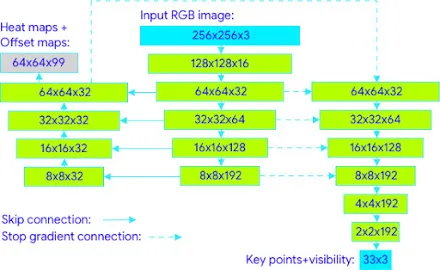

#Installations and dependensies

In [2]:
#@title Mediapipe instalation
!pip install mediapipe

     |████████████████████████████████| 35.6 MB 581 kB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 1.2 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 135 kB 45 kB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 73.2 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 71.6 MB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 71 kB 728 kB/s eta 0:00:01
     |████████████████████████████████| 446 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 118 kB 799 kB/s eta 0:00:01
  Created wheel for jax: filename=jax-0.4.13-py3-none-any.whl size=1518704 sha256=bb921c1531c5f889241d726bb32dd1fe67ee4c649340bc8b744f72f378b3ba01
  Stored in directory: /home/verney/.cache/pip/wheels/46/d9/15/d2800d4089dc4c77299ac7513c6aa1036f5491edbd2bf6ba16


## Download tools from github:

In [1]:
user = "ItayCoifman"
repo = "blazepose-mediapipe-example"
src_dir = "tools"
pyfile = "video.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url};
pyfile = "visualize.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url};
pyfile = "utils.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url};

--2025-12-05 02:17:17--  https://raw.githubusercontent.com/ItayCoifman/blazepose-mediapipe-example/main/tools/video.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7213 (7.0K) [text/plain]
Failed to rename video.py to video.py.1: (2) No such file or directory
Saving to: ‘video.py’

video.py            100%[===================>]   7.04K  42.0KB/s    in 0.2s    

2025-12-05 02:17:18 (42.0 KB/s) - ‘video.py’ saved [7213/7213]

--2025-12-05 02:17:18--  https://raw.githubusercontent.com/ItayCoifman/blazepose-mediapipe-example/main/tools/visualize.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... 

## Imports

In [5]:
# from tools import video,utils,visualize
!pip install tqdm

     |████████████████████████████████| 78 kB 3.4 MB/s eta 0:00:01


In [15]:
from video import Video
import visualize
from utils import landmarks_2_table
import mediapipe as mp
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from IPython.display import clear_output, display
import random



## Functions

In [28]:
def video_pose_estimation(video_path: str,
                          output_path: str = None,
                          save_video: bool = False,
                          verbose: bool = True):
    """
    Applique BlazePose à une vidéo.

    Args:
        video_path: chemin de la vidéo d'entrée.
        output_path: chemin de la vidéo de sortie (si save_video=True).
        save_video: si True, écrit une vidéo annotée.
        verbose: affichage des infos.

    Returns:
        vid_out (Video ou None),
        marker_df,
        visibility_df
    """
    output = []
    timestamps = []

    vid = Video.from_path(video_path)
    video_name = os.path.basename(video_path)

    # Reader
    vid_cap = cv2.VideoCapture(vid.path)

    # Writer optionnel
    video_writer = None
    if save_video:
        if output_path is None:
            base, ext = os.path.splitext(video_path)
            output_path = base + "_pose.mp4"
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        video_writer = cv2.VideoWriter(output_path, fourcc, vid.fps, (vid.width, vid.height))

    if verbose:
        print(f"Processing- Name- {video_name}:")
        print(f" Width- {vid.width}, Height- {vid.height} ")
        print(f" number of frames- {vid.nFrames}, Fps- {vid.fps} ")
        print(f" Path-{video_path} \n")

    # BlazePose
    with mp.solutions.pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as pose:

        for frame_index in tqdm(range(vid.nFrames)):
            success, img = vid_cap.read()
            if not success:
                break

            # BGR -> RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # timestamp
            timestamps.append(vid_cap.get(cv2.CAP_PROP_POS_MSEC))

            # Inference
            results = pose.process(img_rgb)
            output.append(results)

            # Dessin + écriture vidéo seulement si demandé
            if save_video and video_writer is not None:
                img_out = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
                mp.solutions.drawing_utils.draw_landmarks(
                    img_out,
                    results.pose_landmarks,
                    mp.solutions.pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp.solutions.drawing_styles.get_default_pose_landmarks_style()
                )
                video_writer.write(img_out)

    # Fermer ressources
    if video_writer is not None:
        video_writer.release()
    cv2.destroyAllWindows()

    # Landmarks -> tables
    try:
        marker_df, visibility_df = landmarks_2_table(
            output,
            time_vec=np.array(timestamps) / 1000.0
        )
    except Exception as e:
        print("⚠️ landmarks_2_table a échoué:", repr(e))
        marker_df, visibility_df = output, []
        print("please replace the video")

    vid_out = Video.from_path(output_path) if (save_video and output_path is not None) else None
    return vid_out, marker_df, visibility_df


# BlazePose Mediapipe - Extract Pose Estimation From Video:

## Upload your video

In [10]:
#from google.colab import files
# uploaded = files.upload()
# for file_name in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=file_name, length=len(uploaded[file_name])))


In [16]:
# uploads DESRes videos by label
def get_DESRes_videos_by_label(label, n, root="GESRes_filtered_gestures"):
    """
    Retourne n vidéos aléatoires correspondant au label demandé.
    
    - Si n <= nb vidéos disponibles → renvoie n vidéos
    - Si n > nb vidéos disponibles → renvoie toutes les vidéos disponibles et prévient l'utilisateur
    - Si le label n'existe pas → erreur claire
    - Si aucune vidéo pour ce label → erreur claire
    """

    label_path = os.path.join(root, label)

    # 1. Vérifier que le label existe physiquement
    if not os.path.isdir(label_path):
        raise ValueError(
            f"❌ Label '{label}' introuvable.\n"
            f"Labels disponibles : {os.listdir(root)}"
        )

    # 2. Lister les vidéos dans ce dossier
    videos = [f for f in os.listdir(label_path) if f.endswith(".mp4")]

    if len(videos) == 0:
        raise ValueError(f"❌ Aucune vidéo trouvée pour le label '{label}'.")

    available = len(videos)

    # 3. Si la demande dépasse ce qui existe → renvoyer tout
    if n > available:
        print(
            f"⚠️ Seulement {available} vidéos disponibles pour '{label}', "
            f"mais {n} demandées.\n"
            f"👉 Retour de TOUTES les vidéos disponibles."
        )
        selected = videos  # toutes les vidéos
    else:
        selected = random.sample(videos, n)

    # 4. Retourner chemins absolus
    return [os.path.join(label_path, v) for v in selected]


Labels disponibles : ['one', 'finger', 'cup', 'knock', 'clasp', 'hold', 'punch', 'point', 'wave', 'show', 'soft', 'present', 'hand']

In [17]:
#use case
videos = get_DESRes_videos_by_label("point", 10)
videos


['GESRes_filtered_gestures/point/942_Politician3_point_forward.mp4',
 'GESRes_filtered_gestures/point/1173_Clinician1_point_forward.mp4',
 'GESRes_filtered_gestures/point/859_Politician3_point_moving.mp4',
 'GESRes_filtered_gestures/point/834_Politician3_point_to_side.mp4',
 'GESRes_filtered_gestures/point/881_Politician3_point_forward.mp4',
 'GESRes_filtered_gestures/point/1666_Lecturer1_point_forward.mp4',
 'GESRes_filtered_gestures/point/1673_Lecturer1_point_forward.mp4',
 'GESRes_filtered_gestures/point/863_Politician3_point_forward.mp4',
 'GESRes_filtered_gestures/point/2174_Lecturer3_point_to_side.mp4',
 'GESRes_filtered_gestures/point/838_Politician3_point_up.mp4']

## Estimate pose

In [ ]:
output_path = "proc.mp4"
vid, marker_df,visibility_df  = video_pose_estimation(video_path = file_name,output_path =output_path)

Processing- Name- video3.mp4:
 Width- 1446, Height- 882 
 number of frames- 291, Fps- 24.78013426120854 
 Path-video3.mp4 



100%|██████████| 291/291 [00:14<00:00, 20.17it/s]


## Veiw your results
Notice- Convert funciton is only used for presenting Video in google Colab

In [ ]:
vid.convert()
vid.play(frac = 0.75) #change frac acording to the video width and height

Converted to colab freiendly format


# Normalization

In [31]:
KEYPOINTS = [2, 5, 9, 10, 11, 12] + list(range(13, 23))  # 16 joints (visage+haut du corps)
VIS_THRESH = 0.5  # seuil de visibilité (à ajuster si besoin)


def marker_to_traj_vec(marker_df,
                       visibility_df,
                       keypoints=KEYPOINTS,
                       target_len: int = 50,
                       vis_thresh: float = VIS_THRESH) -> np.ndarray:
    """
    Transforme marker_df (T_raw, 100) + visibility_df en une trajectoire
    normalisée et vectorisée pour DMP.

    Accepte indifféremment:
      - marker_df : np.ndarray ou pandas.DataFrame
      - visibility_df : np.ndarray ou pandas.DataFrame

    Retourne:
        traj_vec : (T, 2 * len(keypoints))  -> typiquement (50, 32)
        (coords = (y,z) normalisés par les épaules, resamplés en target_len)
    """

    # ---- 0) Conversion éventuelle DataFrame -> ndarray ----
    if isinstance(marker_df, pd.DataFrame):
        marker_df = marker_df.to_numpy()
    if isinstance(visibility_df, pd.DataFrame):
        visibility_df = visibility_df.to_numpy()

    T_raw = marker_df.shape[0]
    n_kp = len(keypoints)

    # -------- 1) Récupérer le temps --------
    t_src = marker_df[:, 0]  # (T_raw,)

    # -------- 2) Extraire (y, z) pour les keypoints choisis --------
    # marker_df: [time, x0,y0,z0, x1,y1,z1, ...]
    seq_yz = np.zeros((T_raw, n_kp, 2), dtype=float)  # (T_raw, 16, 2)

    for i, kp in enumerate(keypoints):
        base = 1 + 3 * kp  # x = base, y = base+1, z = base+2
        y_col = base + 1
        z_col = base + 2
        seq_yz[:, i, 0] = marker_df[:, y_col]
        seq_yz[:, i, 1] = marker_df[:, z_col]

    # -------- 3) Appliquer le masque de visibilité --------
    # visibility_df: [time, vis_0, vis_1, ..., vis_32]
    vis_sel = np.zeros((T_raw, n_kp), dtype=float)
    for i, kp in enumerate(keypoints):
        vis_col = 1 + kp
        vis_sel[:, i] = visibility_df[:, vis_col]

    # Mettre les points peu visibles à NaN
    mask_invis = (vis_sel < vis_thresh) | ~np.isfinite(vis_sel)
    seq_yz[mask_invis, :] = np.nan

    # -------- 4) Remplir les NaN par interpolation temporelle --------
    # On interpole chaque dimension (joint, coord) indépendamment
    seq_flat = seq_yz.reshape(T_raw, -1)  # (T_raw, n_kp*2)

    for d in range(seq_flat.shape[1]):
        vals = seq_flat[:, d]
        finite = np.isfinite(vals)
        if finite.sum() >= 2:
            # interpolation sur les indices de temps (ou t_src si tu préfères)
            seq_flat[:, d] = np.interp(
                np.arange(T_raw),
                np.arange(T_raw)[finite],
                vals[finite]
            )
        else:
            # si quasi rien de valide : on met à 0
            seq_flat[:, d] = 0.0

    seq_yz_filled = seq_flat.reshape(T_raw, n_kp, 2)  # (T_raw, 16, 2)

    # -------- 5) Normalisation par les épaules (centrage + scale) --------
    # On suppose que 11 et 12 sont dans keypoints
    try:
        idx_sh_l = keypoints.index(11)
        idx_sh_r = keypoints.index(12)
    except ValueError:
        raise ValueError("Les keypoints 11 et 12 (épaules) doivent être dans KEYPOINTS.")

    shoulder_L = seq_yz_filled[:, idx_sh_l, :]  # (T_raw, 2)
    shoulder_R = seq_yz_filled[:, idx_sh_r, :]  # (T_raw, 2)

    centers = 0.5 * (shoulder_L + shoulder_R)  # (T_raw, 2)
    seq_centered = seq_yz_filled - centers[:, None, :]  # (T_raw, 16, 2)

    # Distance épaule-épaule pour chaque frame
    shoulder_dist = np.linalg.norm(shoulder_R - shoulder_L, axis=1)  # (T_raw,)
    finite_sd = shoulder_dist[np.isfinite(shoulder_dist) & (shoulder_dist > 1e-6)]
    if finite_sd.size == 0:
        scale = 1.0
    else:
        scale = np.mean(finite_sd)

    seq_norm = seq_centered / scale  # (T_raw, 16, 2)

    # -------- 6) Normalisation temporelle à target_len frames --------
    if target_len is not None and target_len > 0:
        # On interpole dans le temps réel t_src
        t_new = np.linspace(t_src[0], t_src[-1], target_len)
        seq_norm_flat = seq_norm.reshape(T_raw, -1)  # (T_raw, 32)
        seq_resampled_flat = np.zeros((target_len, seq_norm_flat.shape[1]), dtype=float)

        for d in range(seq_norm_flat.shape[1]):
            seq_resampled_flat[:, d] = np.interp(
                t_new, t_src, seq_norm_flat[:, d]
            )

        seq_resampled = seq_resampled_flat.reshape(target_len, n_kp, 2)  # (target_len, 16, 2)
        T_out = target_len
    else:
        seq_resampled = seq_norm
        T_out = T_raw

    # -------- 7) Vectorisation finale pour DMP : (T_out, 2 * n_kp) --------
    traj_vec = seq_resampled.reshape(T_out, n_kp * 2)  # (T_out, 32)

    return traj_vec


# DMP


In [36]:
class DMPVector:
    def __init__(self, n_basis: int = 20):
        self.n_basis = n_basis #number of gaussians
        self.centers = None
        self.widths = None
        self.W = None       # (n_basis, D)
        self.y0 = None      # (D,)
        self.g = None       # (D,)
        self.T_train = None

    #define each psi function
    def _basis_functions(self, T: int):
        t = np.linspace(0.0, 1.0, T)
        self.centers = np.linspace(0.0, 1.0, self.n_basis)
        self.widths = np.ones(self.n_basis) * (self.n_basis ** 2)
        psi = np.exp(-self.widths * (t[:, None] - self.centers[None, :])**2)
        return psi, t

    def fit(self, Y: np.ndarray):
        """
        Y : (T, D) trajectoire vectorielle (ici D=32)
        """
        T, D = Y.shape
        self.T_train = T
        self.y0 = Y[0].copy()
        self.g  = Y[-1].copy()     #goal point for each trajectory

        psi, t = self._basis_functions(T)   # psi: (T, n_basis)

        # Composante linéaire entre y0 et g pour chaque dimension
        Y_lin = self.y0 + np.outer(t, (self.g - self.y0))   # (T, D)

        # Composante non linéaire à approximer
        F_target = Y - Y_lin                                # (T, D)

        # Normalisation des bases
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum                           # (T, n_basis)

        # Résolution des poids W dans F_target ≈ psi_norm @ W
        # psi_norm: (T, n_basis), F_target: (T, D) -> W: (n_basis, D)
        self.W, _, _, _ = np.linalg.lstsq(psi_norm, F_target, rcond=None)

    def fit_multi(self, Y_batch: np.ndarray):
        """
        Y_batch : (N, T, D) — ensemble de N démos pour un même geste
        Apprend un seul W en empilant toutes les F_target.
        """
        N, T, D = Y_batch.shape
        self.T_train = T

        # base functions communes
        psi, t = self._basis_functions(T)           # (T, n_basis)
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum                    # (T, n_basis)

        # On va empiler toutes les F_target
        F_list = []

        # Pour la partie linéaire de référence, on choisit les moyennes des y0, g
        y0_all = []
        g_all  = []

        for i in range(N):
            Y = Y_batch[i]              # (T, D)
            y0_i = Y[0].copy()
            g_i  = Y[-1].copy()

            y0_all.append(y0_i)
            g_all.append(g_i)

            Y_lin_i = y0_i + np.outer(t, (g_i - y0_i))   # (T, D)
            F_i     = Y - Y_lin_i                        # (T, D)
            F_list.append(F_i)

        # Empilement
        F_all = np.concatenate(F_list, axis=0)           # (N*T, D)
        Psi_big = np.tile(psi_norm, (N, 1))              # (N*T, n_basis)

        # Régression globale
        self.W, _, _, _ = np.linalg.lstsq(Psi_big, F_all, rcond=None)

        # y0, g moyens pour ce geste
        self.y0 = np.mean(np.stack(y0_all, axis=0), axis=0)  # (D,)
        self.g  = np.mean(np.stack(g_all, axis=0),  axis=0)  # (D,)


    def rollout(self, T: int = None, amplitude_scale: float = 1.0) -> np.ndarray:
        """
        Génère une nouvelle trajectoire :
        - T : nombre de pas (si None -> même T que l'entraînement)
        - amplitude_scale : scaling global de la partie non-linéaire
        Retour : (T, D)
        """
        if T is None:
            T = self.T_train

        psi, t = self._basis_functions(T)
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum

        # F: (T, D)
        F = psi_norm @ self.W * amplitude_scale

        # partie linéaire entre y0 et g
        Y_lin = self.y0 + np.outer(t, (self.g - self.y0))

        Y = Y_lin + F
        return Y


In [ ]:
# dmp_vec = DMPVector(n_basis=20)
# traj_vec = marker_to_traj_vec(marker_df,visibility_df)
# T = 50
# dmp_vec.fit(traj_vec) # fit une trajectoire vectorielle -c'est l'extraction puis normalisation des points de la video du dataset

# gen_traj_vec = dmp_vec.rollout(T=T, amplitude_scale=1.0)  # (T, 32)
# print(gen_traj_vec.shape)


NameError: name 'marker_df' is not defined

# Dataset usage



In [ ]:
#Given a label and a number of video, extract marker_df and visibility_df 
#Then, normalize and resample them to build a dataset for DMP training
#output : X (N, T, 32) and video_paths (list of N strings): array of shape (N, T, 32) where N is number of videos

def build_gesture_dataset(label, n, target_len=50):
    video_paths = get_DESRes_videos_by_label(label, n)
    X = []

    for vp in video_paths:
        try:
            # On ne sauvegarde pas de vidéo ici -> save_video=False
            vid_out, marker_df, visibility_df = video_pose_estimation(
                vp, save_video=False, verbose=False
            )

            traj = marker_to_traj_vec(marker_df, visibility_df, target_len=target_len)
            X.append(traj)   # (T, 32)

        except Exception as e:
            print(f"⚠️ Skip {vp} : {repr(e)}")

    if len(X) == 0:
        raise RuntimeError(
            f"❌ Aucune trajectoire n'a pu être extraite pour le label '{label}'."
        )

    X = np.stack(X, axis=0)  # (N, T, 32)
    return X, video_paths


In [35]:
X_point, vids_point = build_gesture_dataset("point", 10, target_len=50)
X_point.shape


I0000 00:00:1764899004.602846    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764899004.603918    7583 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
  0%|          | 0/134 [00:00<?, ?it/s]

100%|██████████| 134/134 [00:03<00:00, 37.50it/s]
I0000 00:00:1764899008.232444    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764899008.232951    7621 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 177/177 [00:04<00:00, 37.47it/s]
I0000 00:00:1764899012.982300    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764899012.982986    7659 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 81/81 [00:02<00:00, 37.33it/s]
I0000 00:00:1764899015.171451    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764899015.171996    7697 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 23/23 [00:00<00:00, 34.78it/s]
I0000 00:00:1764899015.847087 

(10, 50, 32)

# Execution example :
Renvoie Y obtenu avec les 10 démo du label "point"

In [38]:
dmp_point = DMPVector(n_basis=20)
dmp_point.fit_multi(X_point)          # on utilise T et D depuis X_point

Y_gen = dmp_point.rollout(T=50)       # (50, 32)
print(Y_gen.shape)


(50, 32)


# Generalization 
Let's create the dictionnary for each label

In [40]:
gesture_dmps = {}

labels = ['one', 'finger', 'cup', 'knock', 'clasp', 'hold', 'punch', 'point', 'wave', 'show', 'soft', 'present', 'hand']
for lab in labels:
    X_lab, vids_lab = build_gesture_dataset(lab, n=10, target_len=50)
    dmp = DMPVector(n_basis=20)
    dmp.fit_multi(X_lab)
    gesture_dmps[lab] = dmp


I0000 00:00:1764901176.813166    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764901176.813745    9955 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)


⚠️ Seulement 1 vidéos disponibles pour 'one', mais 10 demandées.
👉 Retour de TOUTES les vidéos disponibles.


  0%|          | 0/313 [00:00<?, ?it/s]

100%|██████████| 313/313 [00:08<00:00, 39.07it/s]


⚠️ Seulement 1 vidéos disponibles pour 'finger', mais 10 demandées.
👉 Retour de TOUTES les vidéos disponibles.


I0000 00:00:1764901184.876893    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764901184.878421    9995 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 88/88 [00:02<00:00, 37.41it/s]
I0000 00:00:1764901187.281433    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


⚠️ Seulement 8 vidéos disponibles pour 'cup', mais 10 demandées.
👉 Retour de TOUTES les vidéos disponibles.


I0000 00:00:1764901187.283182   10034 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 33/33 [00:00<00:00, 35.64it/s]
I0000 00:00:1764901188.237290    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764901188.237743   10072 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 28/28 [00:00<00:00, 35.76it/s]
I0000 00:00:1764901189.050651    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764901189.051140   10110 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 23/23 [00:00<00:00, 34.08it/s]
I0000 00:00:1764901189.769080    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764901189.771079   10148 gl_context.cc:357] GL version: 3.2 (OpenGL E

⚠️ Seulement 1 vidéos disponibles pour 'knock', mais 10 demandées.
👉 Retour de TOUTES les vidéos disponibles.


I0000 00:00:1764901195.042363    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764901195.043120   10338 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 52/52 [00:01<00:00, 36.41it/s]
I0000 00:00:1764901196.503614    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


⚠️ Seulement 5 vidéos disponibles pour 'clasp', mais 10 demandées.
👉 Retour de TOUTES les vidéos disponibles.


I0000 00:00:1764901196.504137   10377 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 32/32 [00:00<00:00, 34.33it/s]
I0000 00:00:1764901197.464573    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764901197.465032   10417 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 47/47 [00:01<00:00, 34.61it/s]
I0000 00:00:1764901198.852891    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764901198.853353   10456 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 30/30 [00:00<00:00, 33.39it/s]
I0000 00:00:1764901199.796956    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764901199.798372   10494 gl_context.cc:357] GL version: 3.2 (OpenGL E

⚠️ Seulement 1 vidéos disponibles pour 'punch', mais 10 demandées.
👉 Retour de TOUTES les vidéos disponibles.


I0000 00:00:1764901228.086053   10991 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 19/19 [00:00<00:00, 30.60it/s]
I0000 00:00:1764901228.730083    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764901228.730851   11029 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 61/61 [00:01<00:00, 35.51it/s]
I0000 00:00:1764901230.471287    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764901230.471853   11067 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 85/85 [00:02<00:00, 33.88it/s]
I0000 00:00:1764901232.999828    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764901233.000424   11105 gl_context.cc:357] GL version: 3.2 (OpenGL E

⚠️ Seulement 1 vidéos disponibles pour 'wave', mais 10 demandées.
👉 Retour de TOUTES les vidéos disponibles.


I0000 00:00:1764901241.465428   11409 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 43/43 [00:01<00:00, 34.26it/s]
I0000 00:00:1764901242.767907    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764901242.769576   11448 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 95/95 [00:02<00:00, 36.04it/s]
I0000 00:00:1764901245.440559    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764901245.441057   11486 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 108/108 [00:03<00:00, 35.95it/s]
I0000 00:00:1764901248.476228    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764901248.476747   11525 gl_context.cc:357] GL version: 3.2 (OpenGL

⚠️ Seulement 3 vidéos disponibles pour 'soft', mais 10 demandées.
👉 Retour de TOUTES les vidéos disponibles.


I0000 00:00:1764901266.234710    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764901266.235559   11831 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 32/32 [00:00<00:00, 33.26it/s]
I0000 00:00:1764901267.225492    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764901267.226007   11869 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 21/21 [00:00<00:00, 30.88it/s]
I0000 00:00:1764901267.950941    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764901267.952437   11912 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 25/25 [00:00<00:00, 31.99it/s]
I0000 00:00:1764901268.761559    5066 gl_context_egl.cc:85] Successfully initializ

⚠️ Seulement 9 vidéos disponibles pour 'present', mais 10 demandées.
👉 Retour de TOUTES les vidéos disponibles.


100%|██████████| 35/35 [00:01<00:00, 33.70it/s]
I0000 00:00:1764901269.855838    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764901269.857684   12010 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 49/49 [00:01<00:00, 35.06it/s]
I0000 00:00:1764901271.292082    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764901271.292559   12048 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 31/31 [00:00<00:00, 34.68it/s]
I0000 00:00:1764901272.207155    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764901272.207734   12086 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 62/62 [00:01<00:00, 35.74it/s]
I0000 00:00:1764901273.971780    5

In [41]:
for i in labels: 
    print(f"Geste: {i}")
    dmp = gesture_dmps[i]
    Y_gen = dmp.rollout(T=50)
    print(Y_gen.shape)

Geste: one
(50, 32)
Geste: finger
(50, 32)
Geste: cup
(50, 32)
Geste: knock
(50, 32)
Geste: clasp
(50, 32)
Geste: hold
(50, 32)
Geste: punch
(50, 32)
Geste: point
(50, 32)
Geste: wave
(50, 32)
Geste: show
(50, 32)
Geste: soft
(50, 32)
Geste: present
(50, 32)
Geste: hand
(50, 32)


# Results analysis 

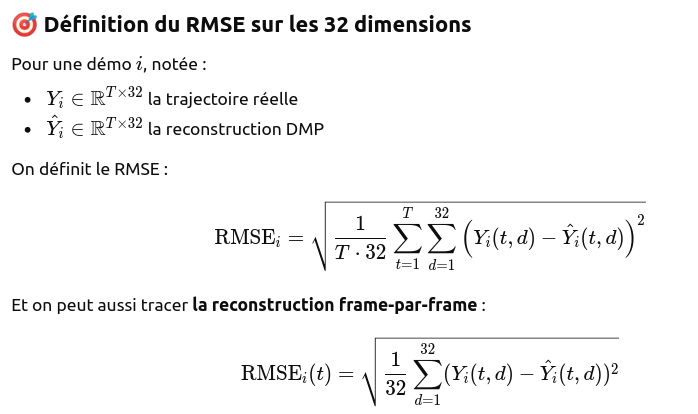

In [ ]:
#Function evaluation DMP reconstruction

def evaluate_dmp_reconstruction(dmp, X_batch):
    """
    X_batch : (N, T, D)
    Retourne :
    - rmse_all : (N,) RMSE globale par démo
    - rmse_per_frame : (N, T) RMSE par frame
    """
    N, T, D = X_batch.shape

    # Reconstructions
    Y_hat = np.zeros_like(X_batch)

    for i in range(N):
        Y_hat[i] = dmp.rollout(T=T)  # Reconstruction DMP

    err = X_batch - Y_hat  # (N, T, D)

    rmse_per_frame = np.sqrt(np.mean(err**2, axis=2))  # (N, T)
    rmse_all = np.sqrt(np.mean(err**2, axis=(1,2)))    # (N,)

    return rmse_all, rmse_per_frame

In [70]:
def analyse_label(label, n=100, target_len=50, n_basis=20):
    """
    Construit le dataset pour `label`, entraîne un DMP multi-démos,
    calcule les RMSE et trace RMSE par frame (toutes les vidéos + moyenne).

    Retourne :
      - rmse_all        : (N,) RMSE globale par démo
      - rmse_per_frame  : (N, T) RMSE à chaque frame
      - dmp             : le DMPVector entraîné
      - X               : (N, T, D) les trajectoires utilisées
      - vids            : liste des chemins de vidéos
    """

    # 1) Dataset
    X, vids = build_gesture_dataset(label, n=n, target_len=target_len)

    # 2) Train DMP multi-démos
    dmp = DMPVector(n_basis=n_basis)
    dmp.fit_multi(X)

    # 3) Evaluate reconstruction
    rmse_all, rmse_per_frame = evaluate_dmp_reconstruction(dmp, X)

    # 4) Stats globales
    # print(f"\n=== Résultats pour le label: {label} ===")
    # print("RMSE par démo :", rmse_all)
    # print("RMSE moyenne :", rmse_all.mean())
    # print("RMSE max :", rmse_all.max())
    # print("Number of videos ", rmse_all.shape[0])
    # 5) Plot RMSE per frame
    plt.figure(figsize=(10, 5))
    for i in range(rmse_per_frame.shape[0]):
        plt.plot(rmse_per_frame[i], alpha=0.25)

    # Courbe moyenne
    plt.plot(rmse_per_frame.mean(axis=0), color='red', linewidth=3, label='Moyenne')

    plt.title(f"RMSE par frame pour le geste '{label}'")
    plt.xlabel("Frame")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

    return rmse_all, rmse_per_frame, dmp, X, vids

Utiliser fonction analyse_label("label") pour visualiser les résultats obtenus pour un label.

I0000 00:00:1764917317.155873    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


⚠️ Seulement 18 vidéos disponibles pour 'point', mais 100 demandées.
👉 Retour de TOUTES les vidéos disponibles.


I0000 00:00:1764917317.157215   32410 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:00<00:00, 28.84it/s]
I0000 00:00:1764917318.160044    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764917318.160563   32448 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 81/81 [00:02<00:00, 30.60it/s]
I0000 00:00:1764917320.859752    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764917320.860960   32486 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 39/39 [00:01<00:00, 30.18it/s]
I0000 00:00:1764917322.196376    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
100%|██████████| 45/45 [00:01<00:00, 30.55it/s]
I0000 00:00:1764917323.703386    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764917323.704061   32564 gl_context.cc:357] GL version: 3.2 (

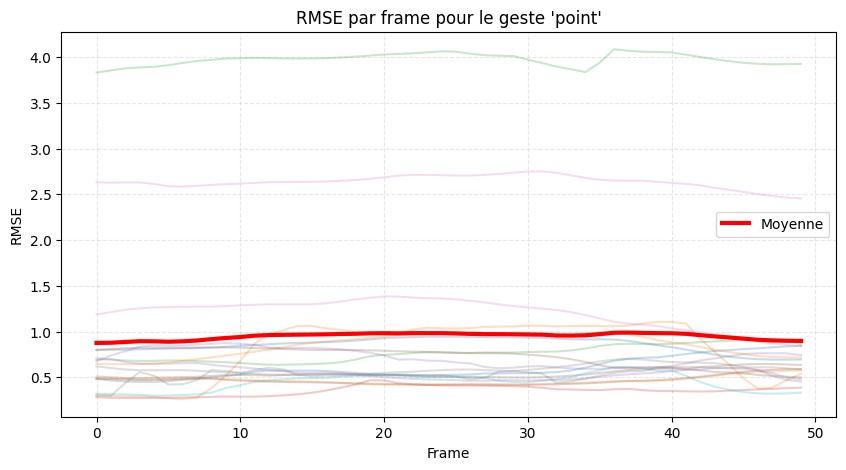

(array([0.85724366, 0.86930955, 0.7692229 , 0.35766779, 0.72944643,
        0.52592615, 2.63904572, 0.58671748, 0.46683778, 0.45528445,
        0.60891913, 0.857317  , 3.97745385, 0.46755467, 0.55432327,
        0.74149108, 1.21031736, 0.53412417]),
 array([[0.80190416, 0.80131623, 0.80162392, 0.80496495, 0.80925727,
         0.8126943 , 0.81519677, 0.81787452, 0.82362181, 0.832911  ,
         0.84256481, 0.85211397, 0.86148007, 0.8689604 , 0.87437633,
         0.87907148, 0.88384581, 0.89033777, 0.90028461, 0.91251591,
         0.92665783, 0.93416156, 0.93961116, 0.94192507, 0.94274803,
         0.94254012, 0.94101353, 0.93863938, 0.93650463, 0.93572013,
         0.93388954, 0.93028095, 0.92281279, 0.91601667, 0.91312666,
         0.91494978, 0.91204927, 0.89747085, 0.87452724, 0.84979475,
         0.82841563, 0.80175438, 0.77353559, 0.7478444 , 0.72469526,
         0.70798393, 0.69675454, 0.6919646 , 0.69212095, 0.69384254],
        [0.30886664, 0.2948527 , 0.2919577 , 0.29082261, 0.

In [71]:
analyse_label("point")


I0000 00:00:1764911381.847817    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764911381.854649   19878 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 27/27 [00:00<00:00, 29.28it/s]
I0000 00:00:1764911382.812821    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764911382.813411   19916 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 91/91 [00:02<00:00, 33.39it/s]
I0000 00:00:1764911385.590660    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
100%|██████████| 35/35 [00:01<00:00, 27.97it/s]
I0000 00:00:1764911386.868460    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764911386.869007   20020 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/hold/2157_Lecturer3_hold_close.mp4 : AttributeError("'list' object has no attribute 'shape'")


100%|██████████| 61/61 [00:01<00:00, 34.79it/s]
I0000 00:00:1764911530.322395    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764911530.324099   22539 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 139/139 [00:03<00:00, 37.17it/s]
I0000 00:00:1764911534.115620    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764911534.117152   22577 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 29/29 [00:00<00:00, 32.24it/s]
I0000 00:00:1764911535.048775    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764911535.049292   22615 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 177/177 [00:04<00:00, 36.63it/s]
I0000 00:00:1764911539.913820 

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/hold/2099_Lecturer3_hold_close.mp4 : AttributeError("'list' object has no attribute 'shape'")


100%|██████████| 100/100 [00:02<00:00, 36.52it/s]
I0000 00:00:1764911588.349493    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764911588.350123   23615 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 225/225 [00:06<00:00, 37.46it/s]
I0000 00:00:1764911594.408799    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764911594.410221   23655 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 83/83 [00:02<00:00, 33.41it/s]
I0000 00:00:1764911596.940993    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
100%|██████████| 131/131 [00:03<00:00, 36.99it/s]
I0000 00:00:1764911600.529648    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764911600.530240   23733 gl_context.cc:357] GL version:


=== Résultats pour le label: hold ===
RMSE par démo : [0.19248505 0.15940372 0.14324566 0.110057   0.33228196 0.34775529
 0.27543382 0.15167899 0.12619402 0.26198028 0.14290539 0.18381026
 0.13512762 0.10090331 0.10876213 0.23868678 0.1542327  0.20134125
 0.16160954 0.09376069 0.29801283 0.18992742 0.28112519 0.16465161
 0.31158297 0.51289795 0.18876715 0.21235724 0.18959225 0.1928598
 0.95047093 0.0982571  0.2165261  0.0977574  0.13455856 0.11253112
 0.19997205 0.75605981 0.12281515 0.35414942 0.13842384 0.16953543
 0.20014889 0.09812817 0.34708013 0.20679776 0.13712327 0.11090355
 0.26636043 0.10845266 0.13072984 0.27727193 0.15895049 0.18041253
 0.15002609 0.17147775 0.14370734 0.19751784 0.26366539 0.38931341
 0.09390863 0.69671345 0.32823685 0.10410203 0.11079803 0.13855364
 0.11478966 0.28510459 0.1406677  0.19067886 0.10764372 0.10947075
 0.07165336 0.1292897  0.07780687 0.29041098 0.12932149 0.2512463
 0.13750436 0.09249175 0.20921598 0.11247086 0.12702144 0.23237551
 0.118590

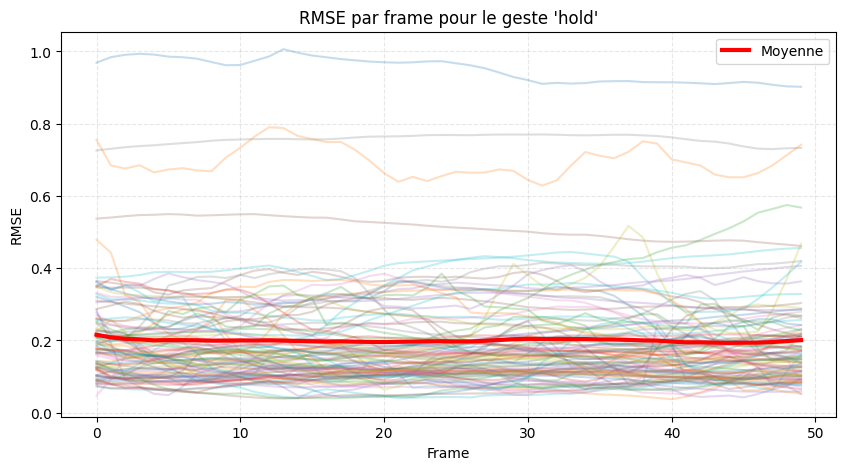

(array([0.19248505, 0.15940372, 0.14324566, 0.110057  , 0.33228196,
        0.34775529, 0.27543382, 0.15167899, 0.12619402, 0.26198028,
        0.14290539, 0.18381026, 0.13512762, 0.10090331, 0.10876213,
        0.23868678, 0.1542327 , 0.20134125, 0.16160954, 0.09376069,
        0.29801283, 0.18992742, 0.28112519, 0.16465161, 0.31158297,
        0.51289795, 0.18876715, 0.21235724, 0.18959225, 0.1928598 ,
        0.95047093, 0.0982571 , 0.2165261 , 0.0977574 , 0.13455856,
        0.11253112, 0.19997205, 0.75605981, 0.12281515, 0.35414942,
        0.13842384, 0.16953543, 0.20014889, 0.09812817, 0.34708013,
        0.20679776, 0.13712327, 0.11090355, 0.26636043, 0.10845266,
        0.13072984, 0.27727193, 0.15895049, 0.18041253, 0.15002609,
        0.17147775, 0.14370734, 0.19751784, 0.26366539, 0.38931341,
        0.09390863, 0.69671345, 0.32823685, 0.10410203, 0.11079803,
        0.13855364, 0.11478966, 0.28510459, 0.1406677 , 0.19067886,
        0.10764372, 0.10947075, 0.07165336, 0.12

In [69]:
analyse_label("hold")

# Analyse de tous les labels en même temps

I0000 00:00:1764917351.099216    5066 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


⚠️ Seulement 1 vidéos disponibles pour 'one', mais 200 demandées.
👉 Retour de TOUTES les vidéos disponibles.


I0000 00:00:1764917351.099870   33112 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
100%|██████████| 313/313 [00:09<00:00, 32.72it/s]


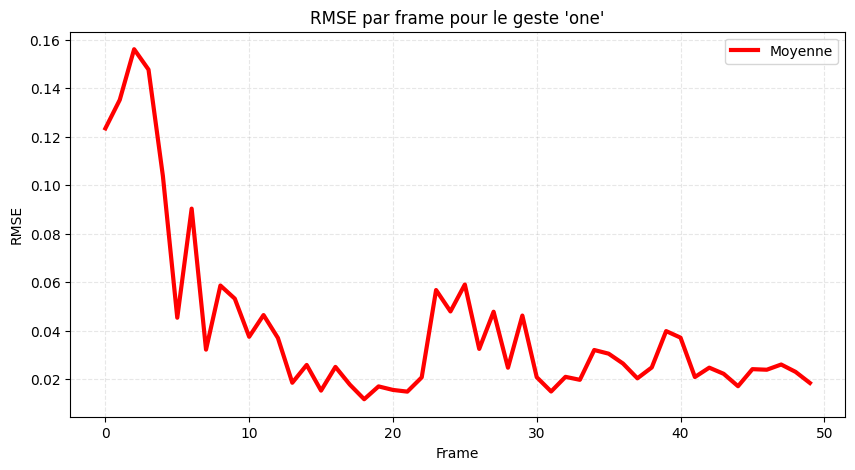

(array([0.053734]),
 array([[0.12343927, 0.13520004, 0.15607213, 0.1476706 , 0.10379593,
         0.04540525, 0.09036812, 0.03225766, 0.0586699 , 0.0532688 ,
         0.03755554, 0.04651172, 0.03704803, 0.01860406, 0.02594769,
         0.01536678, 0.02513994, 0.0178442 , 0.01181322, 0.01709697,
         0.01564237, 0.01494178, 0.02081881, 0.05681569, 0.04799735,
         0.05909893, 0.03254319, 0.04788219, 0.02479488, 0.04630279,
         0.02088807, 0.01499686, 0.02103801, 0.01980586, 0.03209877,
         0.0305865 , 0.02652601, 0.02042604, 0.02490605, 0.03989518,
         0.03719504, 0.02095763, 0.02482002, 0.02228897, 0.01717477,
         0.02420813, 0.02396886, 0.02611588, 0.02309006, 0.01850355]]),
 array([[[ 0.58556992,  0.10170705,  0.55713273, ...,  1.72502818,
          -1.27301508, -1.47203059],
         [ 0.56458106,  0.07760553,  0.54549224, ...,  1.837     ,
          -0.63885949, -1.02886712],
         [ 0.56822375,  0.13202368,  0.55019806, ...,  1.68595949,
          -0

In [72]:
def analyse_full(): 
    for i in labels:
        return analyse_label(i, n=200, target_len=50, n_basis=20)
    
analyse_full()